In [25]:
from functions import *
from xgboost import XGBRegressor

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import pyDOE3 as doe

In [26]:
# Исходные данные
n_samples = 200 # количество данныз в датасете (если не какая-то специальная матрица плана)
limits = (-10, 10) # пределы варьирования признаков
function_name = 'ridge_demo_8d'# имя функции по которй мы генерим искуственный датасет
random_seed = 88 # набор для генерации случайных чисел
test_ratio = 0.1 # количество данных (от всей выборки) которые мы выделяем на тестирование модели
matrix_type = 'lhs'  #варианты: 'ff2n', 'pbdesign', 'bbdesign', 'ccdesign', 'lhs', 'random_uniform', 'd_eff', 'bdesign', 'Taguchi'
taguchi_number = "L81(3^40)"

In [27]:
# Генерим искусственный датасет для обучения, для этого:
# Определяем функцию
main_function = Functions() # Инициализация класса для хранения функции
main_function.limits = limits # назначаем пределы варьирования
main_function.random_seed = random_seed # назначаем набор для генерации случайных чисел
functions = main_function.get_function_dict() # словарь с доступными нам функциями
main_function.set_function(functions[function_name]) # собственно назначаем функцию на основе которой будем данные генерить
# Определяем матрицу планирвоания эксперимента (сначала в кодированном масштабе)
if matrix_type == 'Taguchi':
    taguchi_plan = doe.get_orthogonal_array(taguchi_number)
    scaling_factor = int(np.max(taguchi_plan)-1)
    training_X_coded = taguchi_plan[:,:main_function.n_features]-scaling_factor
else:
    training_matrix = Generate_coded_data(main_function, n_samples, random_seed=random_seed) # инициализация класса
    training_matrix.set_matrix_type(matrix_type, degree = 1) # определение типа матрицы планирования
    training_X_coded = training_matrix.X_coded # генерация матрицы плана в кодированном масштабе (в данном случае Латинский гиперкуб)

# Пересчитываем матрицу планирования из кодированного в натуральный масштаб и определяем вектор целевой переменной
training_data = Generate_natural_data(main_function, training_X_coded) # инициализация объекта для генерации данных в натуральном масштабе
training_data.convert_coded_to_natural() # пересчитываем матрицу планирования из кодированного в натуральный масштаб
training_features = training_data.features # создаем переменную признаков в натуральном масштабе
training_target = training_data.target # создаем переменную для выходной функции

In [28]:
# Генерим искусственный датасет для тестирования модели для этого:
if training_X_coded.shape[0] < 100:
    n_test_samples = int(training_X_coded.shape[0] * 0.5)
else:    
    n_test_samples = int(n_samples * test_ratio) # определяем количество точек для тестирвоания модели
testing_matrix = Generate_coded_data(main_function, n_test_samples, random_seed=random_seed+1) # инициируем объект создания матрицы в кодированном масштабе
testing_matrix.set_matrix_type('random_uniform') # генерация точек для тестирования в кодированном масштабе 
testing_X_coded = testing_matrix.X_coded # создаем переменную для тестирования в кодированном масштабе
testing_data = Generate_natural_data(main_function, testing_X_coded) # инициализируем объект для перевода из кодированного в натуральный масштаб
testing_data.convert_coded_to_natural() # конвертация точек для проверки из кодированного в натуральный масштаб
testing_features = testing_data.features # переменная признаков для тестирвоания
testing_target = testing_data.target # переменная целевой функции для тестирования

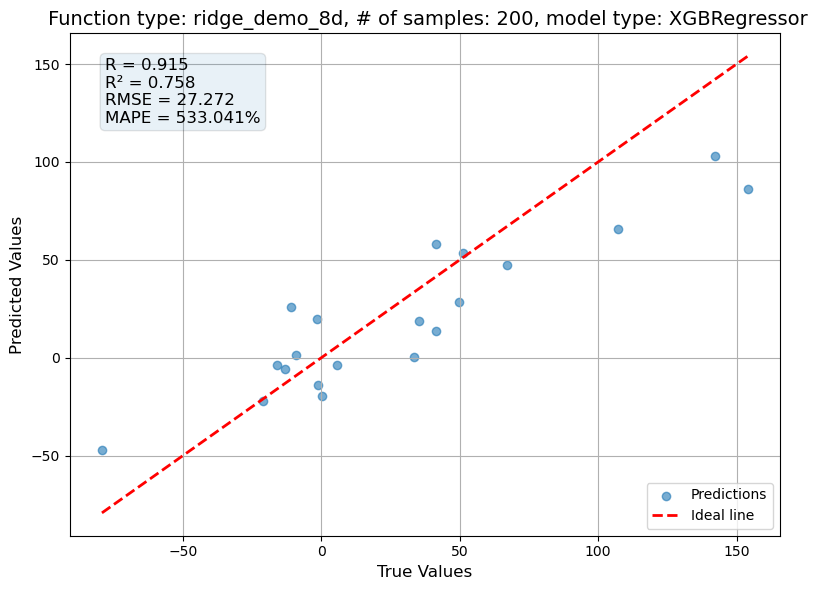

In [29]:
# Обучение модели (на основе XGBRegressor)
# создаем модель
model = XGBRegressor(
                    n_estimators=1000,
                    max_depth=2,
                    learning_rate=0.1,
                    reg_alpha=0.5,
                    reg_lambda=0.1,
                    subsample=0.9,
                    random_state=random_seed,
                    verbosity=0
                    )
# обучаем модель
model.fit(training_X_coded, training_target);
# Расчитываем отклик по данным для проверки
y_pred_test = model.predict(testing_X_coded)

# Посмотрим на график паритета
title = f" Function type: {function_name}, # of samples: {training_X_coded.shape[0]}, model type: XGBRegressor"
plot_true_vs_predicted(testing_target, y_pred_test,  title=title)

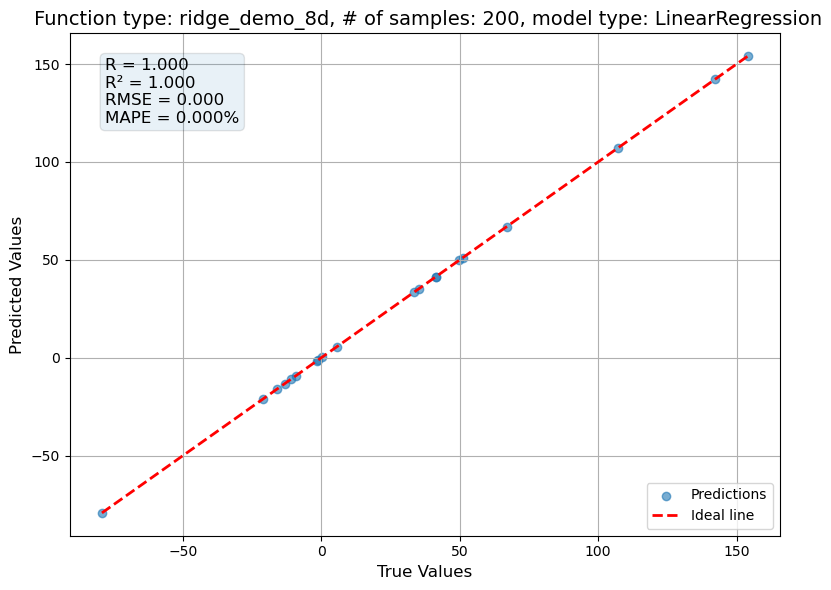

In [30]:
# Обучение модели (на основе LinearRegression)
# создаем модель
# Создаём пайплайн: полином 2-й степени + линейная регрессия
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only = False, order='F')),
    ('linreg', LinearRegression())
])

# Train the model using the training sets
model.fit(training_X_coded, training_target);
# Расчитываем отклик по данным для проверки
y_pred_test = model.predict(testing_X_coded)

# Посмотрим на график паритета
title = f" Function type: {function_name}, # of samples: {training_X_coded.shape[0]}, model type: LinearRegression"
plot_true_vs_predicted(testing_target, y_pred_test,  title=title)

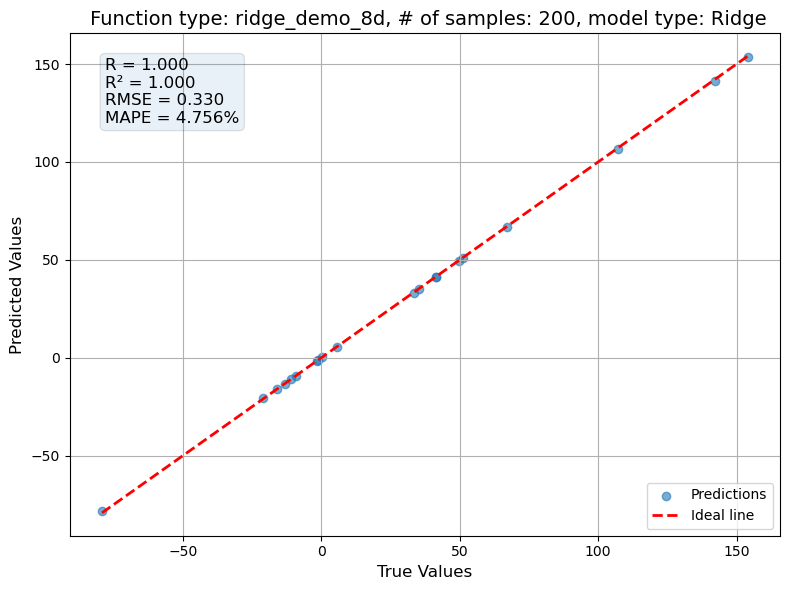

In [31]:
# Обучение модели (на основе RidgeRegression)
# создаем модель
# Создаём пайплайн: полином 2-й степени + линейная регрессия
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only = False, order='F')),
    ('Ridge', Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, solver='auto', tol=0.001))
                ])

# Train the model using the training sets
model.fit(training_X_coded, training_target);
# Расчитываем отклик по данным для проверки
y_pred_test = model.predict(testing_X_coded)

# Посмотрим на график паритета
title = f" Function type: {function_name}, # of samples: {training_X_coded.shape[0]}, model type: Ridge"
plot_true_vs_predicted(testing_target, y_pred_test,  title=title)

Оптимальное alpha: 0.001


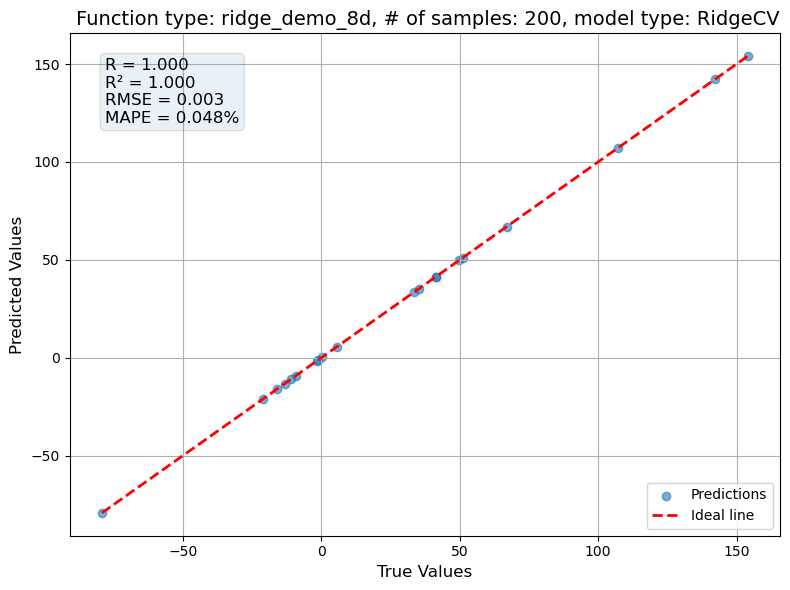

In [32]:
# Обучение модели (на основе RidgeCV)
# создаем модель
# Логарифмическая сетка значений alpha для перебора
alphas = np.logspace(-3, 2, 50)  # от 0.0001 до 100



# Создаём пайплайн: полином 2-й степени + линейная регрессия
model = Pipeline([
                ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only = False, order='F')),
                ('RidgeCV', RidgeCV(
                                    alphas=alphas,
                                    fit_intercept=False,   # потому что include_bias=True уже добавляет столбец единиц
                                    cv=5,                  # можно указать число фолдов или объект CV
                                    store_cv_results=False ))
                ])

# Train the model using the training sets
model.fit(training_X_coded, training_target);
# Расчитываем отклик по данным для проверки
y_pred_test = model.predict(testing_X_coded)

# посмотрим на оптимальное значение alpha
print(f"Оптимальное alpha: {model.named_steps['RidgeCV'].alpha_}")

# Посмотрим на график паритета
title = f" Function type: {function_name}, # of samples: {training_X_coded.shape[0]}, model type: RidgeCV"
plot_true_vs_predicted(testing_target, y_pred_test,  title=title)